In [1]:
import warnings
warnings.filterwarnings("ignore")

import torchaudio as ta
ta.set_audio_backend("sox_io")
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler
# from torch_lr_finder import LRFinder
import pytorch_lightning as pl

import numpy as np
import os

import IPython.display as ipd

import numpy as np

import math

import glob

from tqdm.auto import tqdm

from python_files.Noise_Reduction_Datagen_fp16 import Signal_Synthesis_DataGen

import warnings

warnings.filterwarnings("ignore")

import gc

# from numba import jit

In [2]:
from fastai.text.all import *
from fastai.data.core import DataLoaders

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
torch.__version__

'1.7.1'

In [5]:
torch.cuda.is_available()

True

In [6]:
# torch.set_default_dtype(torch.float16)
# torch.set_default_tensor_type(torch.FloatTensor)

In [7]:
noise_dir = "./dataset/UrbanSound8K-Resampled/"
signal_dir = "./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips/"
signal_nums_save = "./dataset_loader_files/signal_paths_nums_save.npy"
num_noise_samples=1000
num_signal_samples = 100
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = True
n_fft=1024
win_length=n_fft
hop_len=n_fft//4
create_specgram = False
perform_stft = False
default_sr = 16000
sec = 2
augment=True
device_datagen = "cpu"

train_ds = Signal_Synthesis_DataGen(noise_dir, signal_dir, \
                signal_nums_save=signal_nums_save, num_noise_samples=num_noise_samples, \
                num_signal_samples=num_signal_samples, noise_path_save=noise_save_path, train=train, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

Loading nums from npy file
100


In [8]:
train = False
val_ds = Signal_Synthesis_DataGen(noise_dir, signal_dir, \
                signal_nums_save=signal_nums_save, num_noise_samples=num_noise_samples, \
                num_signal_samples=num_signal_samples, noise_path_save=noise_save_path, train=train, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

Loading nums from npy file
100


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 4
shuffle = True
num_workers = 8
pin_memory = False

In [10]:
dls = DataLoaders.from_dsets(train_ds, val_ds, bs=BATCH_SIZE, num_workers=num_workers, pin_memory=pin_memory).to(device)

In [11]:
for index, data in dls.train:
    print(data[0].shape)

torch.Size([1, 32000])


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data = next(self.dataset_iter)
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/fastai/data/load.py", line 110, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/fastcore/basics.py", line 213, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/fastai/data/load.py", line 125, in do_item
    try: return self.after_item(self.create_item(s))
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/fastai/data/load.py", line 131, in create_item
    def create_item(self, s):  return next(self.it) if s is None else self.dataset[s]
  File "/mnt/nvme0n1p2/vamsik1211/Data/git-repos/Noise-Reduction-Deep-Learning/python_files/Noise_Reduction_Datagen_fp16.py", line 256, in __getitem__
    signal_noise_add, signal = self.get_ids(idx)
  File "/mnt/nvme0n1p2/vamsik1211/Data/git-repos/Noise-Reduction-Deep-Learning/python_files/Noise_Reduction_Datagen_fp16.py", line 196, in get_ids
    signal_noise_add, signal = self.develop_data(signal_path, noise_path)
  File "/mnt/nvme0n1p2/vamsik1211/Data/git-repos/Noise-Reduction-Deep-Learning/python_files/Noise_Reduction_Datagen_fp16.py", line 214, in develop_data
    noise, nsr = ta.load(noise_path)
  File "/home/vamsik1211/Data/anaconda3/envs/test/lib/python3.7/site-packages/torchaudio/backend/sox_io_backend.py", line 105, in load
    filepath, frame_offset, num_frames, normalize, channels_first)
RuntimeError: Only 16 and 32 bits are supported for signed PCM.


In [12]:
class InstantLayerNormalization(nn.Module):
    def __init__(self, in_shape, out_shape):
        self.in_shape = in_shape
        self.out_shape = out_shape
        
        self.epsilon = 1e-7
        self.gamma = None
        self.beta = None
        
        super(InstantLayerNormalization, self).__init__()
        
        self.gamma = torch.ones(out_shape)
        self.gamma = nn.Parameter(self.gamma)
        
        self.beta = torch.zeros(out_shape)
        self.beta = nn.Parameter(self.beta)
        
    def forward(self, inps):
        mean = inps.mean(-1, keepdim=True)
        variance = torch.mean(torch.square(inps - mean), dim=-1, keepdim=True)
        std = torch.sqrt(variance + self.epsilon)
        
        outs = (inps - mean) / std
        print(outs.shape, self.gamma.shape)
        outs = outs * self.gamma
        outs = outs + self.beta
        
        return outs
    
class Multiply():
    def __init__(self):
        super(Multiply, self).__init__()
    
    def forward(self, ten1, ten2):
        mul_out = torch.mul(ten1, ten2)
        return mul_out

class NoiseReducer(nn.Module):
    def __init__(self, default_sr, n_fft, win_length, hop_len, sec, dropout=0.5, batch_first=True, stride=2, normalized=False, bidir=False):
        
        self.default_sr = default_sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_len = hop_len
        self.sec = sec
        self.normalized = normalized
        
        self.conv_filters = 256
        
        # Universal LSTM Units
        self.batch_first = True
        self.dropout = 0.25
        self.bidir = bidir
        self.lstm_prelu_ins = int(np.floor(((default_sr*sec) - (win_length - 1) - 1)/ hop_len + 5))
        
        # LSTM 1 UNITS
        self.rnn1_dims = n_fft // 2 + 1
        self.hidden_size_1 = 256
        self.num_layers = 2
       
        
        # LSTM 2 UNITS
        self.rnn2_dims = self.conv_filters
        self.hidden_size_2 = self.hidden_size_1
        
        # Conv1d Layer Units
        self.conv1_in = 1
        self.conv1_out = self.conv_filters
        
        
        
        # InstanceNorm Layer Units
        self.instance1_in = self.rnn1_dims
        self.instance2_in = self.conv1_out
        
        # Dense1 Layer Units
        self.dense1_in = self.hidden_size_1
        self.dense1_out = self.rnn1_dims #int(np.floor(((default_sr*sec) - (win_length - 1) - 1)/ hop_len + 5))#3))
        
        # Dense2 Layer Units
        self.dense2_in = self.hidden_size_2
        self.dense2_out = self.conv1_out
        
        # Dense3 Layer Units
        self.dense3_in = self.hidden_size_1
        self.dense3_out = self.rnn1_dims
        
        # Conv2d Layer Units
        self.conv2_in = self.dense2_out
        self.conv2_out = self.conv_filters
        

        super(NoiseReducer, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=self.rnn1_dims, hidden_size=self.hidden_size_1, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
        self.lstm3 = nn.LSTM(input_size=self.rnn1_dims, hidden_size=self.hidden_size_1, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
#         self.lstm1_1 = nn.LSTMCell(input_size=self.rnn1_dims, hidden_size==self.hidden_size_1, )
        
        print(self.rnn2_dims)
        self.lstm2 = nn.LSTM(input_size=self.rnn2_dims, hidden_size=self.hidden_size_2, num_layers=self.num_layers*2, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
        
        
        self.instancenorm1 = nn.InstanceNorm1d(self.rnn1_dims)
        self.instancenorm2 = nn.InstanceNorm1d(self.rnn2_dims)
        self.instancenorm3 = nn.InstanceNorm1d(self.rnn1_dims)
        
        self.dense1 = nn.Linear(self.dense1_in, self.dense1_out)
        self.dense2 = nn.Linear(self.dense2_in, self.dense2_out)
        self.dense3 = nn.Linear(self.dense3_in, self.dense3_out)
        
        self.conv1 = nn.Conv1d(self.conv1_in, self.conv1_out, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(self.conv2_in, self.conv2_out, kernel_size=3, stride=1, padding=1)
        
        self.prelu_conv1 = nn.PReLU(self.conv1_out)
        self.prelu_conv2 = nn.PReLU(self.conv2_out)
        
        self.prelu_lstm1 = nn.PReLU(self.lstm_prelu_ins)
        self.prelu_lstm3 = nn.PReLU(self.lstm_prelu_ins)
        self.prelu_lstm2 = nn.PReLU(self.hidden_size_2)
        
    @torch.jit.export
    def stft_layer(self, sig):
        
        sig_stft = torch.stft(sig, n_fft=self.n_fft, hop_length=self.hop_len, win_length=self.win_length)
        
#         sig_cplx = torch.view_as_complex(sig_stft)
#         mag = sig_cplx.abs().permute(0, 2, 1)
#         angle = sig_cplx.angle().permute(0, 2, 1)

        mag = sig_stft[:,:,:,0].permute(0, 2, 1)
        angle = sig_stft[:,:,:,1].permute(0, 2, 1)
        
        return [mag, angle]
    
    @torch.jit.export
    def istft_layer(self, mag, angle):
        mag = mag.permute(0, 2, 1)
        angle = angle.permute(0, 2, 1)
        mag = torch.unsqueeze(mag, dim=-1)
        angle = torch.unsqueeze(angle, dim=-1)
        pre_stft = torch.cat((mag, angle), dim=-1)
        stft_sig = torch.istft(pre_stft, n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_len)
        
        return stft_sig
    
    @torch.cuda.amp.autocast()
    def forward(self, inp_tensor):
        
        mag, angle = self.stft_layer(inp_tensor)
        mag_norm = self.instancenorm1(mag)
        angle_norm = self.instancenorm3(angle)
        
        x_mag, hidden_states_mag = self.lstm1(mag_norm)
        x_angle, hidden_states_angle = self.lstm3(angle_norm)

        mask_mag = F.relu(self.dense1(x_mag))
        estimated_mag = torch.mul(mag, mask_mag)
        
        mask_angle = F.relu(self.dense3(x_angle))
        estimated_angle = torch.mul(angle, mask_angle)
        
        signal = self.istft_layer(estimated_mag, estimated_angle)
        signal = signal.unsqueeze(dim=1)

        feature_rep = self.conv1(signal)
        feature_rep = self.prelu_conv2(feature_rep)
        
        feature_norm = self.instancenorm2(feature_rep)
        feature_norm = feature_norm.permute(0, 2, 1)
        x, hidden_states = self.lstm2(feature_norm)
        mask = self.dense2(x)
        feature_mask = F.relu(mask)
        feature_mask = feature_mask.permute(0, 2, 1)

        estimate_feat = torch.mul(feature_rep, feature_mask)
        
        estimate_frames = (self.conv2(estimate_feat))
        estimate_frames = self.prelu_conv2(estimate_frames)
        estimate_sig = torch.sum(estimate_frames, dim=1)
        
        return estimate_sig


In [13]:
class Negative_SNR_Loss(nn.Module):
    def __init__(self):
        super(Negative_SNR_Loss, self).__init__()
    
    def forward(self, sig_pred, sig_true):
        
        sig_true_sq = torch.square(sig_true)
        sig_pred_sq = torch.square(sig_true - sig_pred)

        sig_true_mean = torch.mean(sig_true_sq)
        sig_pred_mean = torch.mean(sig_pred_sq)

        snr = sig_true_mean / sig_pred_mean + 1e-7
        loss = -1*torch.log10(snr)

        return loss

In [14]:
class Mod_MSELoss(nn.Module):
    def __init__(self, mul_factor):
        super(Mod_MSELoss, self).__init__()
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.mul_factor = mul_factor
        
        
    def forward(self, sig_pred, sig_true):
        loss = self.loss_fn(sig_pred, sig_true)
        loss = self.mul_factor*loss
        return loss

In [15]:
use_scripted_model = False
w_decay = 1e-4

if not use_scripted_model:
    print("Using Primary model")
    model = NoiseReducer(default_sr=default_sr, n_fft=n_fft, win_length=win_length, hop_len=hop_len, sec=sec).to(device)
    model.to(device)
else:
    print("Using Scripted Model")
    model = scripted_model

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
# criterion = nn.MSELoss(reduction="mean")#Negative_SNR_Loss()
criterion = Mod_MSELoss(mul_factor=1000)
n_epochs=100


model.train()
scaler = torch.cuda.amp.GradScaler()

Using Primary model
256


In [ ]:
trainer = pl.Trainer()

In [16]:
data = train_ds.__getitem__(1)

In [17]:
# model.load_state_dict(torch.load("./Model_saves/bestmodel.pth"))

In [18]:
learn = Learner(dls, model, loss_func=criterion, model_dir="./Model_saves/", cbs=[ShowGraphCallback(), SaveModelCallback(monitor='valid_loss', fname='bestmodel', every_epoch=True)]).to_fp16()

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0002754228771664202)

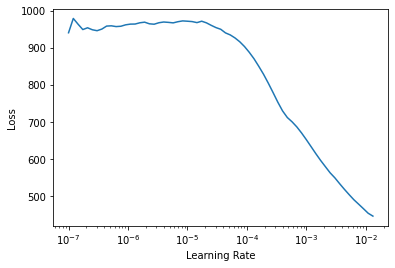

In [19]:
learn.lr_find()

In [20]:
learn.lr = 0.001096478197723627

In [21]:
learn.fine_tune(50)

IndexError: list index out of range

In [ ]:
# fake_inputs = torch.randn(BATCH_SIZE, int(default_sr*sec)).type(torch.float32).to(device)
# outs = model(fake_inputs)
# outs.shape

In [ ]:
model.load_state_dict(torch.load("./Model_saves/Pytorch_model_2_save_LSTM_512_filters.pt"))

In [ ]:
# scaler = torch.cuda.amp.GradScaler()

# for epoch in range(1, n_epochs+1):
    
#     loop = tqdm(enumerate(data_loader), leave=True, total=len(data_loader))
#     train_loss = np.zeros((len(data_loader)))
#     loop.set_description(f"Epoch: [ {epoch}/{n_epochs} ]\t")

    
#     for index, (data, target) in loop:
        
#         data = data.to(device)
#         target = target.to(device)

#         optimizer.zero_grad(set_to_none=True)
        
#         with torch.cuda.amp.autocast():
#             output = model(data)
#             loss = criterion(output, target)
            
#         scaler.scale(loss).backward()
#         for group in optimizer.param_groups:
#             for param in group["params"]:
#                 param.data = param.data.add(-w_decay * group["lr"], param.data)
#         scaler.step(optimizer)
#         scaler.update()
        
# #         output = model(data)
# #         loss = criterion(output, target)
        
# #         loss.backward()
# #         for group in optimizer.param_groups:
# #             for param in group["params"]:
# #                 param.data = param.data.add(-w_decay * group["lr"], param.data)
# #         optimizer.step()

#         train_loss[index] = loss.item()
#         if np.isnan(loss.item()) or np.isnan(np.sum(train_loss)/index+1e-5):
#             print(f"Data shape = {data.shape}\nTarget Shape = {target.shape}, \nindex = {index}")
#         disp_loss = np.sum(train_loss)/index+1e-5
#         loop.set_postfix(loss = disp_loss)

In [ ]:
param

In [ ]:
optimizer.closure()

In [ ]:
torch.save(model.state_dict(), "./Model_saves/Pytorch_model_2_save_LSTM_512_filters.pt")

In [ ]:
noise_add_sig, main_sig = signal_synthesis_dataset.__getitem__(1000)
noise_add_sig = torch.unsqueeze(noise_add_sig, dim=0).to(device)
main_sig = torch.unsqueeze(main_sig, dim=0).to(device)

In [ ]:
%%time
with torch.no_grad():
    outs = model(noise_add_sig)

In [ ]:
sim_loss = torch.nn.CosineSimilarity()(main_sig, outs)

In [ ]:
(sim_loss)

In [ ]:
outs.shape

In [ ]:
x = outs[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
x = noise_add_sig[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
x = main_sig[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
noise_add_sig.mean()